# Import necessary libraries

In [78]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
# --- 1. Load the Dataset ---
print("--- 1. Loading the Dataset ---")

--- 1. Loading the Dataset ---


In [80]:
try:
    df = pd.read_csv('/content/adult 3.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'adult 3.csv' not found. Please upload the file to your Colab environment.")
    exit() # Exit if the file is not found

Dataset loaded successfully!


In [81]:
# to check which dataset are added
!ls

'adult 3.csv'   sample_data   tuned_xgboost_salary_predictor.joblib


In [82]:
# Display the first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours

In [83]:
# --- 2. Exploratory Data Analysis (EDA) - Continued & Enhanced Data Cleaning ---
print("\n--- 2. Exploratory Data Analysis (EDA) & Enhanced Data Cleaning ---")


--- 2. Exploratory Data Analysis (EDA) & Enhanced Data Cleaning ---


In [84]:
# Replace '?' with NaN for proper handling of missing values
# This is crucial as '?' is treated as a string value, not a missing indicator by default.
print("\nReplacing '?' with NaN across the dataset...")
df.replace('?', np.nan, inplace=True)
print("Replacement complete.")


Replacing '?' with NaN across the dataset...
Replacement complete.


In [85]:
# Display missing values after '?' replacement
print("\nMissing values after replacing '?' with NaN:")
print(df.isnull().sum())


Missing values after replacing '?' with NaN:
age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64


In [86]:
# Strip whitespace from all string (object) columns
# Many categorical features in this dataset have leading/trailing spaces,
# e.g., ' Private' instead of 'Private', which creates distinct categories.
print("\nStripping whitespace from categorical columns...")
for column in df.select_dtypes(include='object').columns:
    df[column] = df[column].str.strip()
print("Whitespace stripping complete.")


Stripping whitespace from categorical columns...
Whitespace stripping complete.


In [87]:
# Identify categorical and numerical features after initial cleaning
categorical_features = df.select_dtypes(include='object').columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [88]:
# Ensure 'income' is not treated as a feature for imputation or scaling
if 'income' in categorical_features:
    categorical_features.remove('income')

In [89]:
print(f"\nCategorical Features (for imputation/encoding): {categorical_features}")
print(f"Numerical Features (for scaling): {numerical_features}")


Categorical Features (for imputation/encoding): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
Numerical Features (for scaling): ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [90]:
# Handle missing values: Impute categorical features with the most frequent value (mode)
print("\nImputing missing values in categorical features with their mode...")
for col in categorical_features:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"  - Imputed '{col}' with mode: '{mode_val}'")
print("Missing value imputation complete.")


Imputing missing values in categorical features with their mode...
  - Imputed 'workclass' with mode: 'Private'
  - Imputed 'occupation' with mode: 'Prof-specialty'
  - Imputed 'native-country' with mode: 'United-States'
Missing value imputation complete.


/tmp/ipython-input-90-1519201720.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)


In [91]:
# Verify no more missing values in the relevant columns
print("\nTotal missing values after imputation:")
print(df.isnull().sum().sum()) # This should now be 0


Total missing values after imputation:
0


In [92]:
# --- Feature Engineering ---
print("\n--- Feature Engineering ---")


--- Feature Engineering ---


In [93]:
# 1. Handle 'fnlwgt' (final weight): This feature is generally not useful for
#    predicting individual income and can be dropped. It represents population weights.
print("Dropping 'fnlwgt' column as it's not relevant for individual income prediction.")
df.drop('fnlwgt', axis=1, inplace=True)
# Remove 'fnlwgt' from numerical_features list if it was there
if 'fnlwgt' in numerical_features:
    numerical_features.remove('fnlwgt')

Dropping 'fnlwgt' column as it's not relevant for individual income prediction.


In [94]:
# 2. Feature Engineering for 'capital-gain' and 'capital-loss'
#    These features are highly skewed with many zero values.
#    Creating binary indicators can be more effective for classification.
print("Creating binary features for 'capital-gain' and 'capital-loss'...")
df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

Creating binary features for 'capital-gain' and 'capital-loss'...


In [95]:
# Add the new binary features to numerical features list for consistency
# (though they are binary, they are numerical and don't need one-hot encoding)
numerical_features.append('has_capital_gain')
numerical_features.append('has_capital_loss')


In [96]:
# 3. Simplify 'native-country' feature
#    This column has many unique values. Grouping less frequent ones can help.
print("Simplifying 'native-country' by grouping less frequent countries...")
country_counts = df['native-country'].value_counts()
rare_countries = country_counts[country_counts < 500].index # Threshold can be adjusted
df['native-country'] = df['native-country'].replace(rare_countries, 'Other')
print(f"Unique values in 'native-country' after grouping: {df['native-country'].nunique()}")
print(df['native-country'].value_counts())

Simplifying 'native-country' by grouping less frequent countries...
Unique values in 'native-country' after grouping: 3
native-country
United-States    44689
Other             3202
Mexico             951
Name: count, dtype: int64


In [97]:
# Update categorical features list after native-country modification
# (no change needed if it was already in the list, just its values changed)
if 'native-country' not in categorical_features:
    categorical_features.append('native-country')

In [98]:
# --- Target Variable Encoding ---
print("\n--- Target Variable Encoding ---")
# Encode the target variable 'income'
# '<=50K' will be 0, '>50K' will be 1
# This step is critical for classification models.
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
print("Target variable 'income' encoded: '<=50K' as 0, '>50K' as 1.")
print(df['income'].value_counts())


--- Target Variable Encoding ---
Target variable 'income' encoded: '<=50K' as 0, '>50K' as 1.
income
0    37155
1    11687
Name: count, dtype: int64


In [99]:
print("\nEnhanced Data Cleaning and Feature Engineering Complete!")
print("\nDataset Info after cleaning:")
df.info()
print("\nFirst 5 rows of the dataset after cleaning:")
print(df.head())


Enhanced Data Cleaning and Feature Engineering Complete!

Dataset Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               48842 non-null  int64 
 1   workclass         48842 non-null  object
 2   education         48842 non-null  object
 3   educational-num   48842 non-null  int64 
 4   marital-status    48842 non-null  object
 5   occupation        48842 non-null  object
 6   relationship      48842 non-null  object
 7   race              48842 non-null  object
 8   gender            48842 non-null  object
 9   capital-gain      48842 non-null  int64 
 10  capital-loss      48842 non-null  int64 
 11  hours-per-week    48842 non-null  int64 
 12  native-country    48842 non-null  object
 13  income            48842 non-null  int64 
 14  has_capital_gain  48842 non-null  int64 
 15  has_capital_loss

In [100]:
# Models to compare
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

Advanced Model Training and Comparative Evaluation

In [101]:
print("--- Starting Advanced Model Training and Comparative Evaluation ---")

--- Starting Advanced Model Training and Comparative Evaluation ---


In [102]:
# --- Define Features (X) and Target (y) ---
print("\nDefining features (X) and target (y)...")
X = df.drop('income', axis=1)
y = df['income']
print(f"X shape: {X.shape}, y shape: {y.shape}")


Defining features (X) and target (y)...
X shape: (48842, 15), y shape: (48842,)


In [103]:
# --- Identify Numerical and Categorical Features for Preprocessing ---
# Re-identify them as 'fnlwgt' was dropped and new features were added in cleaning.
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [104]:
print(f"\nNumerical Features for Preprocessing: {numerical_features}")
print(f"Categorical Features for Preprocessing: {categorical_features}")


Numerical Features for Preprocessing: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'has_capital_gain', 'has_capital_loss']
Categorical Features for Preprocessing: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


In [105]:
# --- Split Data into Training and Testing Sets ---
print("\nSplitting data into training and testing sets (80/20 split, stratified)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")


Splitting data into training and testing sets (80/20 split, stratified)...
Training set shape: X_train=(39073, 15), y_train=(39073,)
Testing set shape: X_test=(9769, 15), y_test=(9769,)


In [106]:
# --- Create Preprocessing Pipeline (ColumnTransformer) ---
# This preprocessor will be used for all models to ensure consistency.
print("\nSetting up preprocessing steps with ColumnTransformer...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
print("Preprocessor configured.")


Setting up preprocessing steps with ColumnTransformer...
Preprocessor configured.


In [107]:
# --- Define Models to Train ---
# We'll use a dictionary to store different models with their respective pipelines.
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [108]:
# Dictionary to store accuracy scores for comparison
accuracy_scores = {}
roc_curves = {} # To store FPR, TPR for ROC plot


--- Training and Evaluating: Logistic Regression ---
Logistic Regression is a simple yet powerful linear model often used as a baseline.
It's good for understanding feature importance and is computationally efficient.
Training Logistic Regression...
Logistic Regression training complete!

Logistic Regression Accuracy: 0.8567

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      7431
        >50K       0.75      0.60      0.67      2338

    accuracy                           0.86      9769
   macro avg       0.82      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769


Logistic Regression Confusion Matrix:
[[6973  458]
 [ 942 1396]]


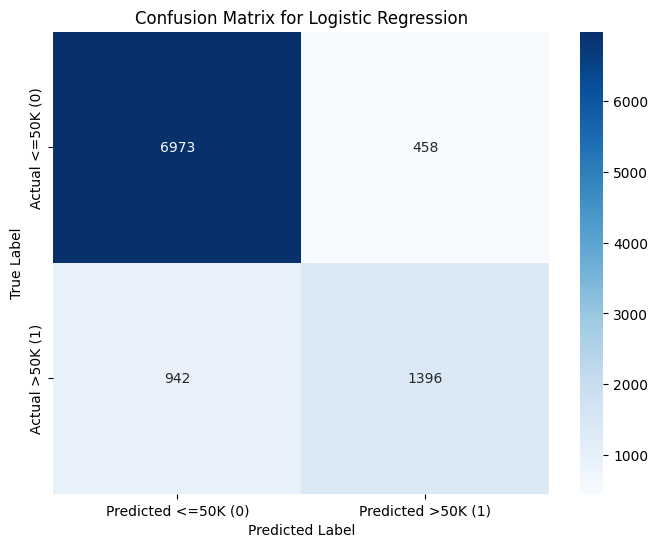

  AUC: 0.9071

--- Training and Evaluating: Random Forest ---
Random Forest is an ensemble method that builds multiple decision trees and merges their predictions.
It's robust to overfitting, handles non-linear relationships, and provides good accuracy.
Training Random Forest...
Random Forest training complete!

Random Forest Accuracy: 0.8522

Random Forest Classification Report:
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      7431
        >50K       0.72      0.62      0.67      2338

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.79      9769
weighted avg       0.85      0.85      0.85      9769


Random Forest Confusion Matrix:
[[6881  550]
 [ 894 1444]]


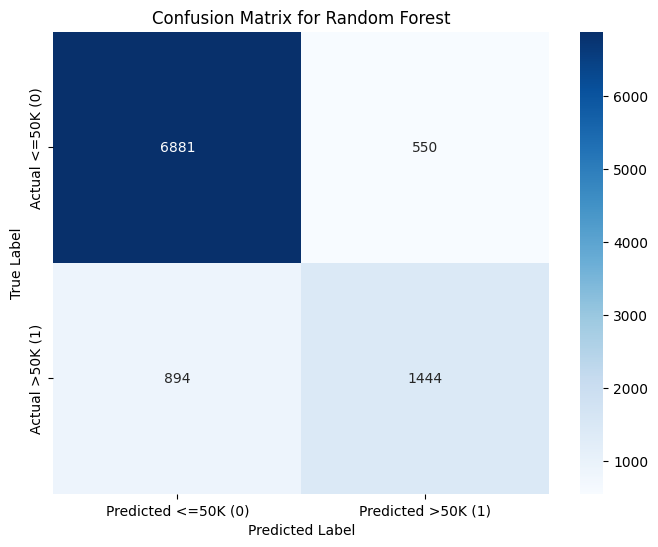

  AUC: 0.8921

--- Training and Evaluating: XGBoost ---
XGBoost (Extreme Gradient Boosting) is an advanced boosting algorithm known for its speed and performance.
It's highly effective for structured data and often wins machine learning competitions.
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:26:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete!

XGBoost Accuracy: 0.8749

XGBoost Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      7431
        >50K       0.78      0.66      0.72      2338

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.87      0.87      9769


XGBoost Confusion Matrix:
[[7006  425]
 [ 797 1541]]


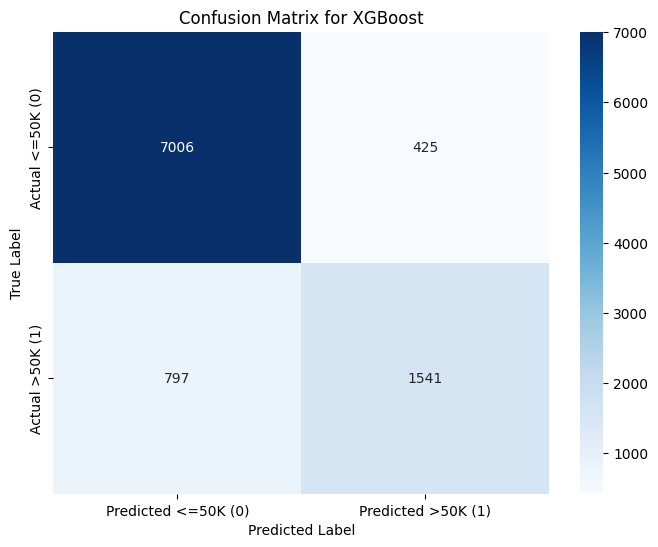

  AUC: 0.9289


In [109]:
# --- Train and Evaluate Each Model ---
for name, model in models.items():
    print(f"\n--- Training and Evaluating: {name} ---")

    # Explanation for model choice
    if name == 'Logistic Regression':
        print("Logistic Regression is a simple yet powerful linear model often used as a baseline.")
        print("It's good for understanding feature importance and is computationally efficient.")
    elif name == 'Random Forest':
        print("Random Forest is an ensemble method that builds multiple decision trees and merges their predictions.")
        print("It's robust to overfitting, handles non-linear relationships, and provides good accuracy.")
    elif name == 'XGBoost':
        print("XGBoost (Extreme Gradient Boosting) is an advanced boosting algorithm known for its speed and performance.")
        print("It's highly effective for structured data and often wins machine learning competitions.")

    # Create a pipeline for the current model
    current_model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train the model
    print(f"Training {name}...")
    current_model_pipeline.fit(X_train, y_train)
    print(f"{name} training complete!")

    # Make predictions
    y_pred = current_model_pipeline.predict(X_test)
    y_proba = current_model_pipeline.predict_proba(X_test)[:, 1] # Probabilities for ROC curve

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = accuracy
    print(f"\n{name} Accuracy: {accuracy:.4f}")

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

    print(f"\n{name} Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Visualize the confusion matrix for the current model
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted <=50K (0)', 'Predicted >50K (1)'],
                yticklabels=['Actual <=50K (0)', 'Actual >50K (1)'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_curves[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    print(f"  AUC: {roc_auc:.4f}")



In [110]:
# --- Comparative Accuracy Visualization ---
print("\n--- Comparative Model Accuracy ---")
models_names = list(accuracy_scores.keys())
accuracies = list(accuracy_scores.values())


--- Comparative Model Accuracy ---


/tmp/ipython-input-111-3327730383.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models_names, y=accuracies, palette='viridis')


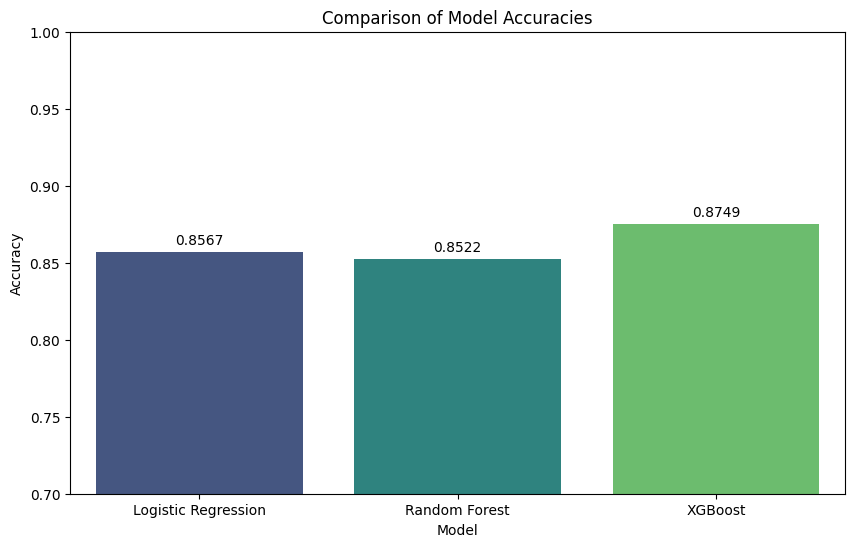

In [111]:
plt.figure(figsize=(10, 6))
sns.barplot(x=models_names, y=accuracies, palette='viridis')
plt.ylim(0.7, 1.0) # Set y-axis limit to better visualize differences
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.005, f'{value:.4f}', ha='center')
plt.show()


--- Comparative ROC Curves ---


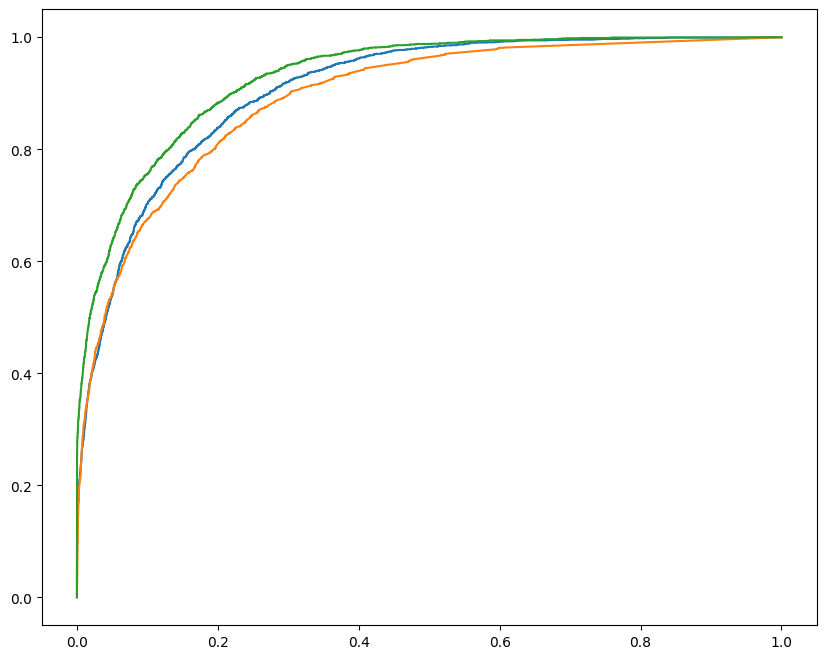

In [112]:
# --- Comparative ROC Curve Visualization ---
print("\n--- Comparative ROC Curves ---")
plt.figure(figsize=(10, 8))
for name, data in roc_curves.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{name} (AUC = {data["auc"]:.4f})')

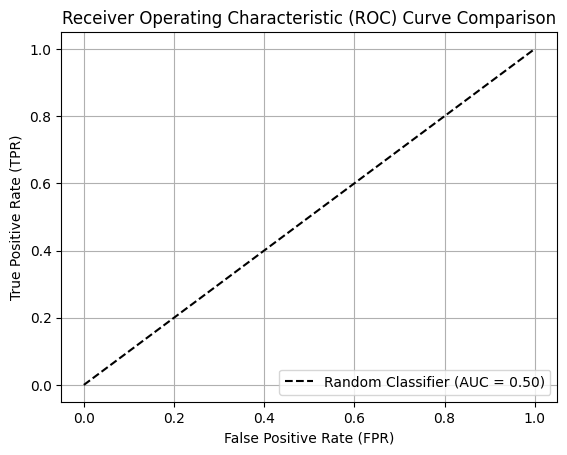

In [113]:
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)') # Dashed diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [114]:
print("\n--- Advanced Model Training and Comparative Evaluation Complete! ---")


--- Advanced Model Training and Comparative Evaluation Complete! ---


In [115]:
# --- Define Features (X) and Target (y) ---
# This part should be consistent with the previous code
X = df.drop('income', axis=1)
y = df['income']

In [116]:
# --- Identify Numerical and Categorical Features for Preprocessing ---
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [117]:
# --- Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Create Preprocessing Pipeline (ColumnTransformer) ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [118]:
print("--- Starting Hyperparameter Tuning for XGBoost Classifier ---")

--- Starting Hyperparameter Tuning for XGBoost Classifier ---


In [119]:
# --- Define the Model Pipeline for Tuning ---
# We create a pipeline specifically for the model we want to tune.
# The 'classifier__' prefix is crucial for GridSearchCV to identify
# hyperparameters belonging to the 'classifier' step in the pipeline.
pipeline_to_tune = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

In [120]:
# --- Define the Parameter Grid for GridSearchCV ---
# These are common hyperparameters for XGBoost.
# The values chosen are a starting point; you might expand or narrow them
# based on initial results and computational resources.
param_grid = {
    'classifier__n_estimators': [100, 200], # Keep it simple: 100 or 200 trees
    'classifier__max_depth': [3, 5], # Shallow trees to avoid overfitting
    'classifier__learning_rate': [0.05, 0.1], # Balanced step sizes
    'classifier__subsample': [0.8, 0.9], # Random sampling to reduce overfitting
    'classifier__colsample_bytree': [0.8, 1.0] # Full or near-full column usage
}

In [121]:
print("\nParameter grid defined for XGBoost tuning:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")


Parameter grid defined for XGBoost tuning:
  classifier__n_estimators: [100, 200]
  classifier__max_depth: [3, 5]
  classifier__learning_rate: [0.05, 0.1]
  classifier__subsample: [0.8, 0.9]
  classifier__colsample_bytree: [0.8, 1.0]


In [122]:
# --- Initialize GridSearchCV ---
# cv=5 means 5-fold cross-validation.
# scoring='accuracy' means the best model will be chosen based on accuracy.
# n_jobs=-1 uses all available CPU cores for faster computation.
print("\nInitializing GridSearchCV (this may take some time)...")
grid_search = GridSearchCV(
    estimator=pipeline_to_tune,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', # Or 'roc_auc' if you prefer to optimize for AUC
    n_jobs=-1,          # Use all available cores
    verbose=2           # Show progress during fitting
)


Initializing GridSearchCV (this may take some time)...


In [123]:
# --- Debugging Prints (Added to help diagnose errors) ---
print("\n--- Debugging Information Before GridSearchCV Fit ---")
print("X_train head:")
print(X_train.head())
print("\ny_train head:")
print(y_train.head())
print("\nX_train info:")
X_train.info()
print(f"\nNumerical features list: {numerical_features}")
print(f"Categorical features list: {categorical_features}")
print("--------------------------------------------------")


--- Debugging Information Before GridSearchCV Fit ---
X_train head:
       age workclass  education  educational-num      marital-status  \
34342   71   Private    HS-grad                9       Never-married   
18559   17   Private       10th                6       Never-married   
12477   27   Private    HS-grad                9  Married-civ-spouse   
560     43   Private    HS-grad                9           Separated   
3427    31   Private  Bachelors               13  Married-civ-spouse   

              occupation    relationship   race  gender  capital-gain  \
34342  Handlers-cleaners   Not-in-family  White    Male             0   
18559              Sales  Other-relative  White  Female             0   
12477      Other-service         Husband  White    Male             0   
560         Adm-clerical       Unmarried  Black  Female             0   
3427     Exec-managerial         Husband  White    Male             0   

       capital-loss  hours-per-week native-country  has_cap

In [124]:
# --- Fit GridSearchCV to the Training Data ---
# This step performs the exhaustive search and cross-validation.
grid_search.fit(X_train, y_train)
print("GridSearchCV fitting complete!")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:27:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV fitting complete!


In [125]:
# --- Get the Best Parameters and Best Score ---
print("\n--- Best Hyperparameters Found ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


--- Best Hyperparameters Found ---
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.9}
Best cross-validation accuracy: 0.8733


In [126]:
# --- Evaluate the Tuned Model on the Test Set ---
print("\n--- Evaluating the Tuned XGBoost Model on Test Set ---")
best_model = grid_search.best_estimator_ # This is the pipeline with the best parameters


--- Evaluating the Tuned XGBoost Model on Test Set ---


In [127]:
y_pred_tuned = best_model.predict(X_test)
y_proba_tuned = best_model.predict_proba(X_test)[:, 1]

In [128]:
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned XGBoost Accuracy on Test Set: {accuracy_tuned:.4f}")


Tuned XGBoost Accuracy on Test Set: 0.8753


In [129]:
print("\nClassification Report for Tuned XGBoost:")
print(classification_report(y_test, y_pred_tuned, target_names=['<=50K', '>50K']))


Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      7431
        >50K       0.79      0.66      0.72      2338

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769



In [130]:
print("\nConfusion Matrix for Tuned XGBoost:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print(cm_tuned)


Confusion Matrix for Tuned XGBoost:
[[7014  417]
 [ 801 1537]]


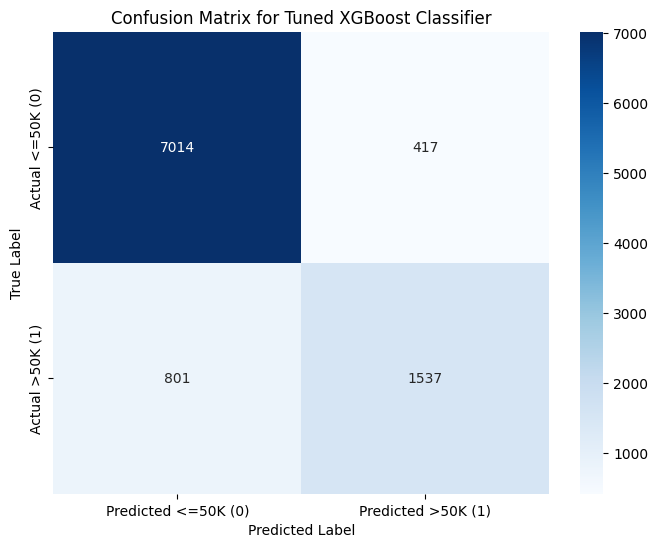

In [131]:
# Visualize the confusion matrix for the tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted <=50K (0)', 'Predicted >50K (1)'],
            yticklabels=['Actual <=50K (0)', 'Actual >50K (1)'])
plt.title('Confusion Matrix for Tuned XGBoost Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [132]:
# Calculate and plot ROC curve for the tuned model
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

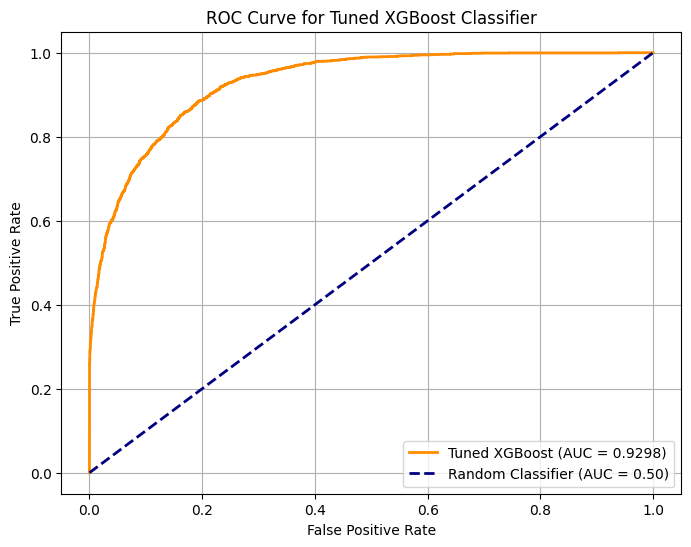

In [133]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='darkorange', lw=2, label=f'Tuned XGBoost (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [134]:
print("\n--- Hyperparameter Tuning Complete! ---")
print("The XGBoost Classifier has been tuned, and its performance with optimal parameters evaluated.")
print(f"Original XGBoost Accuracy (from previous step): [You can manually compare with the value from the previous output]")
print(f"Tuned XGBoost Accuracy: {accuracy_tuned:.4f}")


--- Hyperparameter Tuning Complete! ---
The XGBoost Classifier has been tuned, and its performance with optimal parameters evaluated.
Original XGBoost Accuracy (from previous step): [You can manually compare with the value from the previous output]
Tuned XGBoost Accuracy: 0.8753


In [135]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [136]:
# --- Define Features (X) and Target (y) ---
X = df.drop('income', axis=1)
y = df['income']

In [137]:
# --- Identify Numerical and Categorical Features for Preprocessing ---
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [138]:
# --- Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Create Preprocessing Pipeline (ColumnTransformer) ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [139]:
# --- Define the Model Pipeline for Tuning (as used in previous step) ---
pipeline_to_tune = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])


In [140]:
# --- Define the Parameter Grid for GridSearchCV (as used in previous step) ---
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.8, 1.0]
}

In [141]:
# --- Fit GridSearchCV (if not already done in the current session) ---
# This part assumes GridSearchCV has been run and 'grid_search' object exists.
# If you are running this code in a fresh session, you MUST run the GridSearchCV
# fitting section from the previous step first to get the 'grid_search' object.
print("--- Starting Feature Importance Analysis ---")
print("\nEnsuring GridSearchCV has been fitted to retrieve the best model...")
try:
    # Attempt to access grid_search.best_estimator_
    # If this fails, it means grid_search hasn't been fitted in the current session.
    _ = grid_search.best_estimator_
    print("GridSearchCV object found and ready.")
except NameError:
    print("GridSearchCV object not found. Running GridSearchCV fit now (this may take time)...")
    grid_search = GridSearchCV(
        estimator=pipeline_to_tune,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0 # Set to 0 to suppress verbose output during re-run
    )
    grid_search.fit(X_train, y_train)
    print("GridSearchCV fitting complete for feature importance analysis.")

--- Starting Feature Importance Analysis ---

Ensuring GridSearchCV has been fitted to retrieve the best model...
GridSearchCV object found and ready.


In [142]:
# --- Extract the Best Model and its Classifier ---
best_pipeline = grid_search.best_estimator_
best_xgb_model = best_pipeline.named_steps['classifier']

In [143]:
print("\nBest XGBoost Classifier retrieved from the tuned pipeline.")


Best XGBoost Classifier retrieved from the tuned pipeline.


In [144]:
# --- Get Feature Importances ---
feature_importances = best_xgb_model.feature_importances_

In [145]:
# --- Map Importances to Feature Names ---
# This is the crucial part for interpreting the results, as ColumnTransformer
# transforms features.

# 1. Get names of transformed numerical features
transformed_numerical_features = numerical_features

In [146]:
# 2. Get names of transformed categorical features
# Access the OneHotEncoder from the preprocessor step
one_hot_encoder = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']
transformed_categorical_features = one_hot_encoder.get_feature_names_out(categorical_features)

In [147]:
# 3. Combine all transformed feature names in the correct order
# The ColumnTransformer outputs numerical features first, then categorical.
all_transformed_features = list(transformed_numerical_features) + list(transformed_categorical_features)


In [148]:
# If 'remainder' was 'passthrough', we'd need to add those columns too.
# In our case, all original columns are handled by 'num' or 'cat', so 'passthrough'
# won't add new columns to the transformed output that aren't already accounted for.

# Create a DataFrame for better visualization and sorting
importance_df = pd.DataFrame({
    'Feature': all_transformed_features,
    'Importance': feature_importances
})


In [149]:
# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [150]:
print("\nTop 20 Most Important Features:")
print(importance_df.head(20))


Top 20 Most Important Features:
                              Feature  Importance
33  marital-status_Married-civ-spouse    0.442668
1                     educational-num    0.059528
2                        capital-gain    0.050040
41         occupation_Exec-managerial    0.046380
45           occupation_Other-service    0.034614
3                        capital-loss    0.024418
42         occupation_Farming-fishing    0.022512
55             relationship_Own-child    0.020324
43       occupation_Handlers-cleaners    0.016150
7               workclass_Federal-gov    0.013653
0                                 age    0.013601
57                  relationship_Wife    0.012175
4                      hours-per-week    0.010967
63                      gender_Female    0.010710
54        relationship_Other-relative    0.009861
35       marital-status_Never-married    0.009498
65              native-country_Mexico    0.009247
44       occupation_Machine-op-inspct    0.009156
12         workcl

/tmp/ipython-input-151-4154789158.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


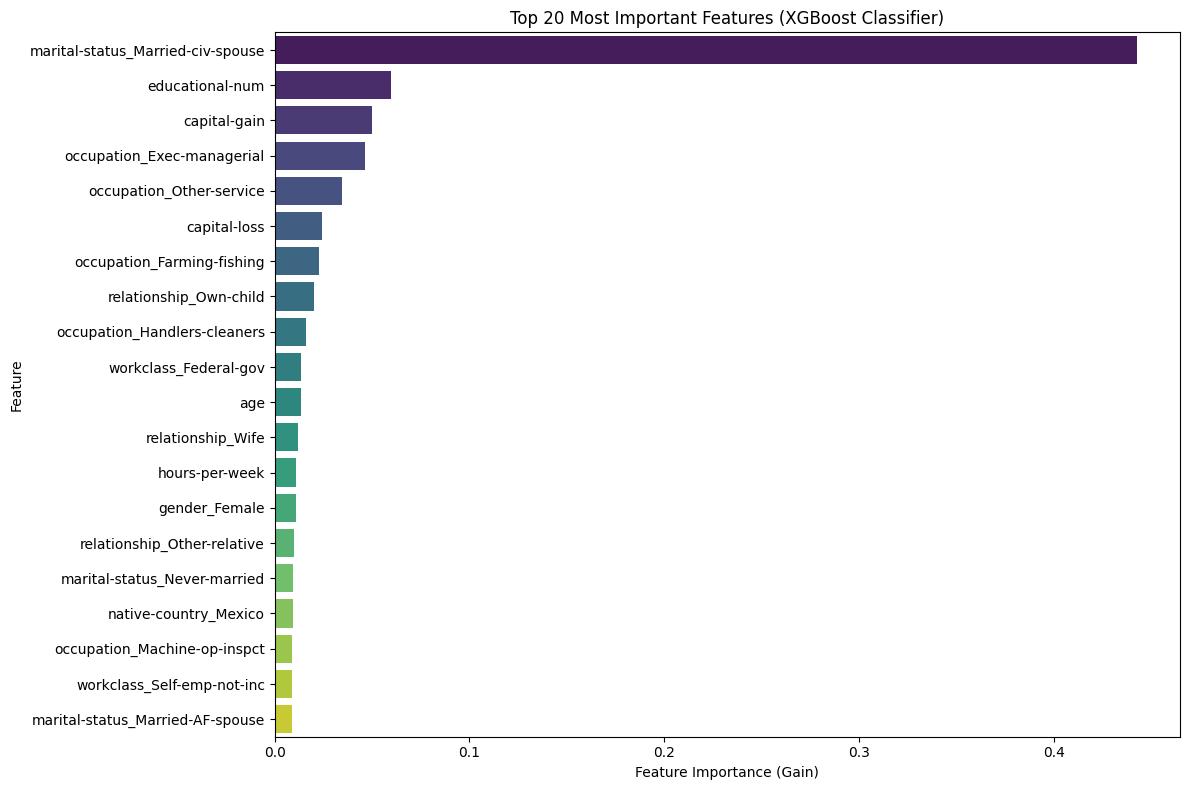

In [151]:
# --- Visualize Feature Importances ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features (XGBoost Classifier)')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [152]:
print("\n--- Feature Importance Analysis Complete! ---")
print("The plot above shows the most influential features in predicting income.")
print("\nInterpretation:")
print("- The 'Importance' score indicates how much each feature contributes to the model's prediction power (typically based on 'gain' for XGBoost, meaning how much the feature improves the model's accuracy).")
print("- Features at the top of the list are more critical for the model's decision-making process.")
print("- For one-hot encoded features (e.g., 'education_Bachelors', 'marital-status_Married-civ-spouse'), the importance refers to that specific category within the feature.")
print("\nThis analysis helps in understanding the underlying factors driving income prediction and can guide further domain-specific insights or feature engineering efforts.")



--- Feature Importance Analysis Complete! ---
The plot above shows the most influential features in predicting income.

Interpretation:
- The 'Importance' score indicates how much each feature contributes to the model's prediction power (typically based on 'gain' for XGBoost, meaning how much the feature improves the model's accuracy).
- Features at the top of the list are more critical for the model's decision-making process.
- For one-hot encoded features (e.g., 'education_Bachelors', 'marital-status_Married-civ-spouse'), the importance refers to that specific category within the feature.

This analysis helps in understanding the underlying factors driving income prediction and can guide further domain-specific insights or feature engineering efforts.


**MODEL DEPLOYMENT**


In [153]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier # Make sure to install xgboost: pip install xgboost
import joblib # For saving the model

print("--- Starting Process to Find and Save the Best Model ---")

# --- 1. Load the Dataset (Re-run if in a new session) ---
# Make sure 'adult 3.csv' is uploaded to your Google Colab environment
try:
    df = pd.read_csv('adult 3.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'adult 3.csv' not found. Please upload the file to your Colab environment.")
    exit()

# --- 2. Data Cleaning (Re-run if in a new session) ---
print("\nPerforming Data Cleaning steps...")
df.replace('?', np.nan, inplace=True)
for column in df.select_dtypes(include='object').columns:
    df[column] = df[column].str.strip()

categorical_cols_for_imputation = df.select_dtypes(include='object').columns.tolist()
if 'income' in categorical_cols_for_imputation:
    categorical_cols_for_imputation.remove('income')

for col in categorical_cols_for_imputation:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

df.drop('fnlwgt', axis=1, inplace=True)
df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

country_counts = df['native-country'].value_counts()
rare_countries = country_counts[country_counts < 500].index
df['native-country'] = df['native-country'].replace(rare_countries, 'Other')

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
print("Data Cleaning complete.")

# --- 3. Define Features (X) and Target (y) ---
print("\nDefining features (X) and target (y)...")
X = df.drop('income', axis=1)
y = df['income']
print(f"X shape: {X.shape}, y shape: {y.shape}")

# --- 4. Identify Numerical and Categorical Features for Preprocessing ---
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()
print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

# --- 5. Split Data into Training and Testing Sets ---
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

# --- 6. Create Preprocessing Pipeline (ColumnTransformer) ---
print("\nSetting up preprocessing steps with ColumnTransformer...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
print("Preprocessor configured.")

# --- 7. Define the Model Pipeline for Tuning ---
print("\nDefining the XGBoost model pipeline for tuning...")
pipeline_to_tune = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])
print("Pipeline for tuning created.")

# --- 8. Define the Parameter Grid for GridSearchCV ---
print("\nDefining the parameter grid for GridSearchCV...")
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.8, 1.0]
}
print("Parameter grid defined.")

# --- 9. Initialize and Fit GridSearchCV ---
print("\nInitializing and fitting GridSearchCV (this will take some time)...")
grid_search = GridSearchCV(
    estimator=pipeline_to_tune,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)
print("GridSearchCV fitting complete!")

# --- 10. Get the Best Model ---
best_model = grid_search.best_estimator_
print("\nBest model (tuned XGBoost pipeline) retrieved from GridSearchCV.")

# --- 11. Save the Best Model using joblib ---
model_filename = 'tuned_xgboost_salary_predictor.joblib'
print(f"\nSaving the best trained model to '{model_filename}' using joblib...")
joblib.dump(best_model, model_filename)
print("Model saved successfully!")

print("\n--- Process Complete: Best Model Found and Saved! ---")
print(f"You can now find '{model_filename}' in your Colab files. This is the file you need to upload for your Streamlit app.")


--- Starting Process to Find and Save the Best Model ---
Dataset loaded successfully!

Performing Data Cleaning steps...


/tmp/ipython-input-153-3218116133.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Data Cleaning complete.

Defining features (X) and target (y)...
X shape: (48842, 15), y shape: (48842,)
Numerical Features: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'has_capital_gain', 'has_capital_loss']
Categorical Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

Splitting data into training and testing sets...
Training set shape: (39073, 15), (39073,)
Testing set shape: (9769, 15), (9769,)

Setting up preprocessing steps with ColumnTransformer...
Preprocessor configured.

Defining the XGBoost model pipeline for tuning...
Pipeline for tuning created.

Defining the parameter grid for GridSearchCV...
Parameter grid defined.

Initializing and fitting GridSearchCV (this will take some time)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:29:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV fitting complete!

Best model (tuned XGBoost pipeline) retrieved from GridSearchCV.

Saving the best trained model to 'tuned_xgboost_salary_predictor.joblib' using joblib...
Model saved successfully!

--- Process Complete: Best Model Found and Saved! ---
You can now find 'tuned_xgboost_salary_predictor.joblib' in your Colab files. This is the file you need to upload for your Streamlit app.
